# Introduction to CNN

Author : Shravan Aras. \
Email : shravanaras@arizona.edu

In [264]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import math
import numpy as np
from torchvision import transforms
import time

Torchvision has ton of toy datasets that can be used to test and train models. For a complete list check out - https://pytorch.org/vision/stable/datasets.html

# Examples of loading the CIFAR dataset.

CIFAR10 contains 10 classes and more than 10,000 images. Checkout the documentation for more details.

In [79]:
# Download the dataset and store it locally. 
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=None)

Files already downloaded and verified


Various classes of images from the dataset.

In [80]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Image data is stored inside `train_data.data`. Lets take a peak at a few of them. As these images are 32x32, and have 3 channels (RGB), their shape will be (n, 32, 32, 3). Where is n is the total number of images. Each dataset item is stored as a tuple of `(PIL.image, Int)` representing the `(Image, class index)`.

In [145]:
classes = train_data.classes

In [81]:
print(train_data.data.shape)
print(type(train_data))
print(type(train_data.data))
print(type(train_data[0]))
print(len(train_data[0])) 
print(type(train_data[0][0]), type(train_data[0][1]))

(50000, 32, 32, 3)
<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'numpy.ndarray'>
<class 'tuple'>
2
<class 'PIL.Image.Image'> <class 'int'>


frog


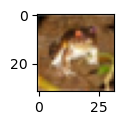

In [82]:
# An Example.

print(train_data.classes[train_data[0][1]])
plt.figure(figsize=(1,1))
plt.imshow(train_data[0][0])

That is a very tiny frog, but I am sure it is a frog!

Let's also look at a few more examples, just for fun!

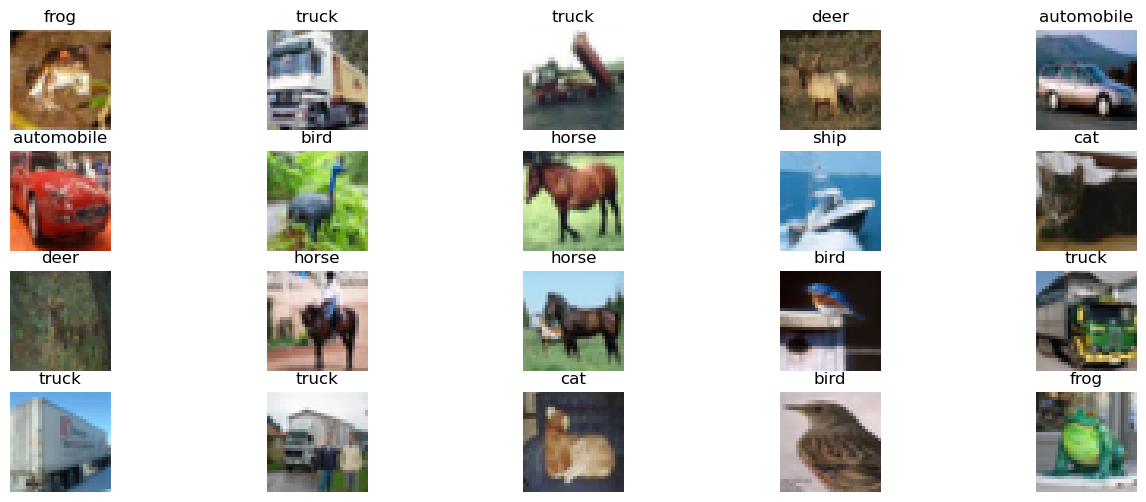

In [83]:
plt.figure(figsize=(16, 6))
images_per_row = 5
total_images = 20
for i in range(0, total_images):
    plt.subplot(math.ceil(total_images/images_per_row), images_per_row, i+1)
    plt.axis('off')
    plt.title(train_data.classes[train_data[i][1]])
    plt.imshow(train_data[i][0])

Let's put this all into a simple method so we can call it anywhere.

In [84]:
def shuffleAndDraw(train_data, total_images=20, images_per_row=5):
    plt.figure(figsize=(16, 6))
    for i, idx in enumerate(np.random.randint(1, train_data.data.shape[0]+1, size=total_images)):
        plt.subplot(math.ceil(total_images/images_per_row), images_per_row, i+1)
        plt.axis('off')
        plt.title(train_data.classes[train_data[idx][1]])
        plt.imshow(train_data[idx][0])

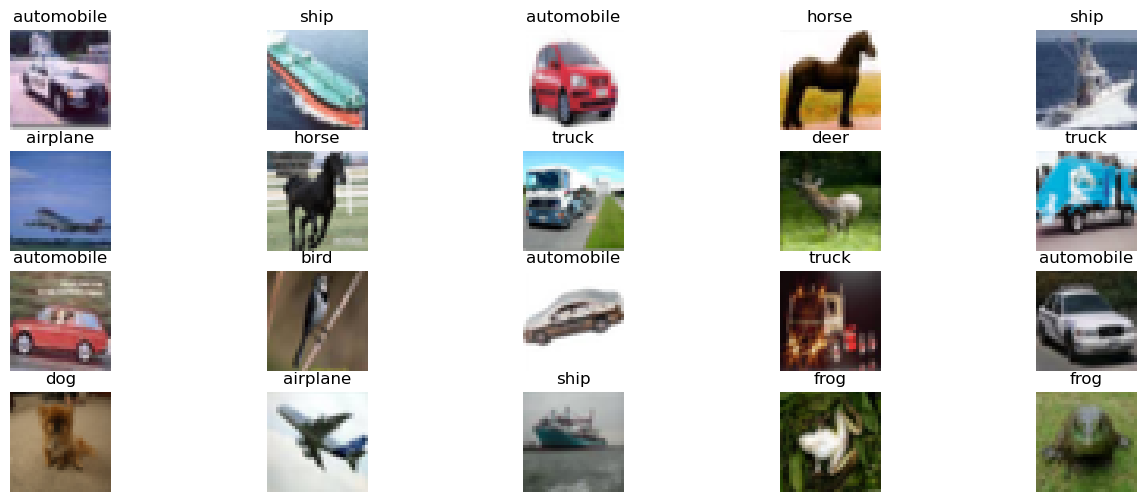

In [85]:
shuffleAndDraw(train_data)

# Applying transformations

Eveything in deep learning is in the form of Tensors. Additionally we should also normalize these images, so that all the tensors are in the same range of $[-1,1]$.
We will be using methods provided by `torchvision.transform` to do this to help speed up things. You can look at the complete documentation here - https://pytorch.org/vision/0.11/transforms.html (legacy). The newer documentation for using `v2.Compose` can be found here https://pytorch.org/vision/stable/transforms.html.

Let's see how we can apply a very simple transformation using some of the methods provided.

<class 'torchvision.transforms.transforms.Compose'>


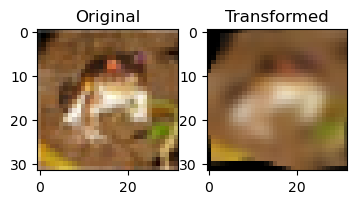

In [101]:
img = train_data[0][0]

# Creating a few image transformations to show it works.
trans = transforms.Compose([
        transforms.GaussianBlur((5, 5)),
        transforms.ElasticTransform(),
        transforms.RandomErasing()
])

print(type(trans))

# Apply this transformation to the image.
img_t = trans(img)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Transformed')
plt.imshow(img_t)

We can also apply this to the complete dataset as we load it. Let's look at how how we can do that. 

In [102]:
train_data_transformed = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=trans)

Files already downloaded and verified


In [116]:
print(train_data_transformed)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
               ElasticTransform(alpha=[50.0, 50.0]), (sigma=[5.0, 5.0]), interpolation={self.interpolation}, fill={self.fill})
               RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
           )


You can see that the dataset now has the transformations added to it.

# Batching the data and shuffling.

AI models are trained in batches, and hence the "Stochastic" in the SGD term. We can certainly batch the images manually, keep track of which label goes where and then wrap an iterator around it to return a single batch of images when iterated on. But this is too much work. Instead we will use `DataLoader` class to some of this heavy lifting.

In [122]:
from torch.utils.data import DataLoader
import multiprocess
import psutil

We want to parallize some of this effort. So lets figure out how many cores we have. I am running a 1st gen Mac M1 Pro.

In [121]:
print(multiprocess.cpu_count())

10


As not all CPU on the M1 are performace cores, with some being energy or low power cores, I think we can go with 4 cores as the number of workers.

**DataLoader needs the dataset to be in Tensors** and hence we must first transform it into that.

In [141]:
trans = transforms.Compose([
        transforms.ToTensor(),  # Converting this to tensors for the data loader.
        transforms.GaussianBlur((5, 5)),
        transforms.ElasticTransform(),
        transforms.RandomErasing()
])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=trans)

Files already downloaded and verified


In [142]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)

In [139]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [156]:
batch_images, batch_labels = next(iter(train_loader))  # Get a batch.

In [157]:
print(batch_images.shape)
print([classes[l] for l in batch_labels])

torch.Size([10, 3, 32, 32])
['horse', 'horse', 'deer', 'ship', 'automobile', 'truck', 'deer', 'deer', 'deer', 'deer']


**Note** - That when PIL images are converted to tensors using `ToTensor()` their representation is changed from `(h, w, channels)` to `(channels, w, h)`. This is also how all PyTorch tensor related methods expect the image to be. Example CNN layers which we will look later on.

In [149]:
batch_images[0].shape

torch.Size([3, 32, 32])

Lets take a look at this

In [159]:
drawable = batch_images.permute(0, 2, 3, 1)  # Permuting the order so we can easily draw it out.
print(drawable.shape)

torch.Size([10, 32, 32, 3])


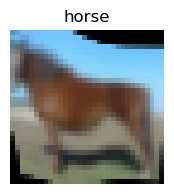

In [163]:
plt.figure(figsize=(2, 2))
plt.title(classes[batch_labels[0]])
plt.axis('off')
plt.imshow(drawable[0])

# Let's design a simple deep CNN network

In [167]:
import torch.nn as nn
import torch.nn.functional as F

In [270]:
class MyModelSimple(nn.Module):
    """
    Let's have some fun defining some simple CNN models.
    """
    def __init__(self):
        super(MyModelSimple, self).__init__()
        # Define all the layers we will use here.
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        """
        Forward pass
        """
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # Flatten out the image.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Convert the output of the final layer into probabilitues for each class.
        
        return x  # Don't forget this, otherwise the model will return a None during prediction

It is sometimes hard to figure out the input and output shapes. Walking manually through some of the 

In [285]:
img_rand = torch.rand(3, 32, 32)
conv1 = nn.Conv2d(3, 6, 5)
img_rand = conv1(img_rand)
print(img_rand.shape)
mp = nn.MaxPool2d(2, 2)
img_rand = mp(img_rand)
print(img_rand.shape)
conv2 = nn.Conv2d(6, 16, 5)
img_rand = conv2(img_rand)
print(img_rand.shape)
img_rand = mp(img_rand)
print(img_rand.shape)

torch.Size([6, 28, 28])
torch.Size([6, 14, 14])
torch.Size([16, 10, 10])
torch.Size([16, 5, 5])


It looks like the dimension before we flatten will be (16, 5, 5)

In [272]:
model = MyModelSimple()
print(model)

MyModelSimple(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


We now have our simple and basic model ready.

**Why are we not passing the final output through `softmax`**

If you look at the final layer of the model, it does not return a probability vector (>0 and sum to 1) but instead logits from the previous layers. This is because the loss function `nn.CrossEntropyLoss()` takes logits as its input along with the class labels, and does the hard work of converting them into probabilities internally. Take a look at its documentation here - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# Defining the loss function and optimizier

In [273]:
import torch.optim as optim

In [274]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Let's now go and train this.

We are going to have to redo some transformation and data loading steps, since we want to normalize the data before passing it through the model as the only transformation to start with.
The 

In [275]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=trans)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                          transform=trans)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Testing out dataloader.

In [289]:
X, Y = next(iter(train_loader))
print(Y)
print(X.shape)

tensor([9, 6, 1, 8, 6, 8, 2, 0, 2, 0])
torch.Size([10, 3, 32, 32])


We can do a quick check to see that data has been normalized between $[-1, 1]$ through our Normalization Transform.

In [297]:
print(torch.min(X), torch.max(X))
print(torch.min(X[0]), torch.max(X[0]))

tensor(-1.) tensor(1.)
tensor(-0.9529) tensor(0.9059)


Just passing random Tensor into the model to make sure it is working correctly.

In [276]:
prediction = model(torch.rand(3, 32, 32))
print(prediction.shape)  # Outputs a tensor of 10, one tensor for each category of the image.

torch.Size([1, 10])


I am going to shift the model to a NN accelerator hardware. You can use `cuda` if you have a GPU that supports it. For M1 macs and above we can use the Metal API for the NN co-processors. 
1. `cuda` for NVIDIA
2. `mps` for Mac M1 and above.

In [280]:
[torch.cuda.is_available(), torch.backends.mps.is_available()]

[False, True]

Lets move our model to our NN accelerator hardware. By default the device is CPU.

In [281]:
device = 'mps'

In [282]:
model = model.to(device)

Writing the train and evaluation loop.

In [300]:
epochs = 2
for epoch in range(epochs):
    # Holds the total loss during training.
    total_loss = 0.0
    epoch_start_time = time.time()
    # Model parameters are trainable.
    model.train()
    
    print(f"----- Epoch {epoch} -----")
    batch_number = 0
    for batch_X, batch_Y in train_loader:
        start_time = time.time()
        # Move the tensors in the batch to the accelerated device.
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        # Make a forward pass of the mode.
        predictions = model(batch_X)
        # Calculate the loss from the prediction.
        loss = loss_fn(predictions, batch_Y)
        
        # Zero out the gradient for the backward pass to update the model 
        # parameters.
        optimizer.zero_grad()
        # Do the differentiation in the backward pass.
        loss.backward()
        # Perform SGD.
        optimizer.step()
        total_loss += loss.item()
        end_time = time.time()
        print(f"\rBatch number {batch_number} -- Training Loss {loss.item()}. Time - {(end_time - start_time):.2f} seconds", end='', flush=True)
        batch_number += 1
    
    print(f"\nAverage Loss {(total_loss/len(train_loader)):.2f} for epoch {epoch} ran in {(time.time() - epoch_start_time):.2f}s")

----- Epoch 0 -----
Batch number 4999 -- Training Loss 1.1306540966033936. Time - 0.00 secondsAverage Loss 1.47 for epoch 0 ran in 50.38s
----- Epoch 1 -----
Batch number 4999 -- Training Loss 1.333741545677185. Time - 0.00 secondsssAverage Loss 1.32 for epoch 1 ran in 51.43s


# Saving the model.

Large models can take a very long time to train, and hence it is a good idea to save the model. We can also save intermediate model weights as checkpoints if we want to 
recover from it.

In [302]:
torch.save(model.state_dict(), './models/simplecnnv1.model')

We can also load the model weights. We do need to know the model architecture.

In [303]:
lmodel = MyModelSimple()
lmodel.load_state_dict(torch.load('./models/simplecnnv1.model'))

<All keys matched successfully>

# Testing out the model in evaluation mode.

Put the model in evaluation mode, so the weights are locked.

In [305]:
lmodel.eval()

MyModelSimple(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [309]:
lmodel = lmodel.to(device)

Get some test data.

In [307]:
test_X, test_Y = next(iter(test_loader))
test_X, test_Y = test_X.to(device), test_Y.to(device)

In [308]:
from torchvision.utils import make_grid

In [310]:
predictions = lmodel(test_X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


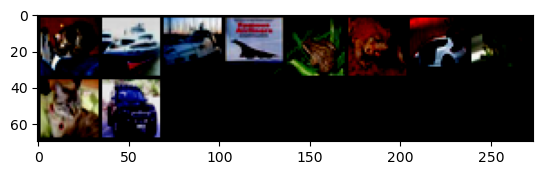

In [328]:
# Remember to bring it back to CPU before we display them. Else we will get an error.
plt.imshow(make_grid(test_X.to('cpu')).permute(1, 2, 0))

**Do the colors look funny and what is that error?** - This is because the image tensor is normalized. We need to denormalize it.

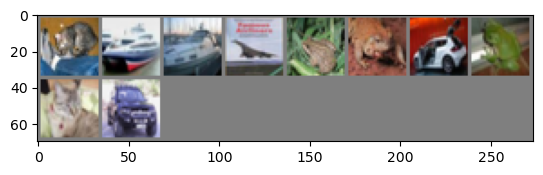

In [332]:
plt.imshow(make_grid(test_X.to('cpu')).permute(1, 2, 0) / 2 + 0.5)  # TODO: Make a section explaining this.

Let's print out the labels for these images.

In [333]:
labels = [classes[l] for l in test_Y]
print(labels)

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


**Predictions** - Now let us look at the predictions from our model.

In [341]:
plabels = [classes[torch.argmax(l)] for l in predictions]
print(plabels)

['cat', 'ship', 'airplane', 'airplane', 'cat', 'frog', 'automobile', 'frog', 'cat', 'automobile']


We see that there are some mis-predictions. That is common, we are using a very simple CNN based model to do this.

In [347]:
acc = [labels[i] == plabels[i] for i in range(len(labels))]
acc = np.array(acc, dtype='int64').sum() / len(acc)
print(f"Accuracy - {acc}")

Accuracy - 0.8


**80% accuracy** is not bad.

# Let's code up to see the overall accuracy.

In [351]:
accuracy = 0.0
lmodel = lmodel.to(device)
for test_X, test_Y in test_loader:
    test_X, test_Y = test_X.to(device), test_Y.to(device)
    predictions = lmodel(test_X)
    plabels = [classes[torch.argmax(l)] for l in predictions]
    acc = [labels[i] == plabels[i] for i in range(len(labels))]
    acc = np.array(acc, dtype='int64').sum()
    accuracy += acc
    
accuracy = accuracy / len(test_loader)
print(f"Overall testing accuracy - {accuracy:.2f}")

Overall testing accuracy - 0.83


We have an overall accuracy of **83%** which is not bad for our first simple CNN experiment.

# Credits and useful links -

1. https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212
2. https://www.cs.toronto.edu/~kriz/cifar.html
3. https://pytorch.org/vision/stable/datasets.html
4. https://pytorch.org/get-started/locally/